In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.ndimage import zoom
import pandas as pd
from pipeline_setup import *
import time
from scipy.optimize import minimize

In [2]:
# Set file locations
advanced_settings_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTanjc08kc5vIN-icUMzMEGA9bJuDesLX8V_u2Ab6zSC4MOhLZ8Jrr18DL9o4ofKIrSq6FsJXhPWu3F/pub?gid=0&single=true&output=csv"

# Read in emissions from other sectors
sector_emissions_dict = set_sector_emissions_dict()
# Read in the advanced settings from the google sheet
params = read_advanced_settings(advanced_settings_url)
# Set the datablock
datablock_init = datablock_setup()

# Set the scenario parameters
params_baseline = set_baseline_scenario(params)

# Also add the baseline parameters to the datablock
datablock_init.update(params_baseline)

In [3]:
# Name the output parameters of the current calculator function 
# (ideally these would be set and returned by the calculator)
z1_name = "SSR"
z2_name = "emissions"

# Name the params we are going to vary
name1 = "horticulture"
name2 = "foresting_pasture"


In [4]:
# Do a test calculation
z1_val_baseline, z2_val_baseline = SSR_emissions(datablock_init, params_baseline, sector_emissions_dict)
#print(f"SSR = {SSR_result:.8f}; GHG = {emissions_result:.8f}")
print(f"{z1_name} = {z1_val_baseline:.8f}; {z2_name} = {z2_val_baseline:.8f}")
# This is my checksum for debugging: 
# SSR = 0.67366432; GHG = 94.22954995

SSR = 0.67366432; emissions = 85.59217570


In [5]:
# Create an objective function suitable for giving to the scipy minimizer 
def ffc_objective(x, names_x, z_name_requested, datablock_init, params_default, sector_emissions_dict):
    """
    Objective function for the minimizer, which calculates the SSR and emissions
    based on the input parameters and returns the requested value.
    
    Parameters:
    - x: array-like, the input parameters to be varied
    - names_x: list of strings, the names of the parameters in x
    - z_name_requested: string, the name of the output parameter to return
    - datablock_init: the initial data block for the calculation
    - params_default: dictionary, the default parameters to be used in the calculation
    - sector_emissions_dict: dictionary, emissions data for other sectors
    
    Returns:
    - fun: float, the value of the requested output parameter (SSR or emissions)
    """

    # Set the verbosity - this should be taken out of the function really
    verbosity = 2
    
    # Set up the x vector using the default values plus this point
    params = params_default.copy()
    for i_name, name_string in enumerate(names_x):
        params[name_string] = x[i_name]

    # Get ready to call the calculator (ideally this would all be inside the calculator)
    z1_name = "SSR"
    z2_name = "emissions"
    names_z = (z1_name, z2_name)

    # Call the calculator
    z1_val, z2_val = SSR_emissions(datablock_init, params, sector_emissions_dict)

    # Store up the results 
    ffc_results = dict()
    ffc_results[z1_name] = z1_val  
    ffc_results[z2_name] = z2_val  

    # Print out what's going on 
    if (verbosity > 1):
        for i_name, name_string in enumerate(names_x):
            print(f"{name_string} = {x[i_name]:.10f}; ", end="")
        for i_name, name_string in enumerate(names_z):
            print(f"{name_string} = {ffc_results[name_string]:.10f}; ", end="")
        print()

    # Choose which single value to return, as this is what the minimiser wants
    # Surely also a way to return all the results??? Just pass ffc_results in and then modify in here?
    fun = ffc_results[z_name_requested]
    
    return fun

In [6]:
class FFCObjectiveWithCache:
    def __init__(self, names_x, datablock_init, params_default, sector_emissions_dict):
        self.names_x = names_x
        self.datablock_init = datablock_init
        self.params_default = params_default
        self.sector_emissions_dict = sector_emissions_dict
        self._cache = {}

    def _calculate(self, x_tuple):
        # Only recompute if not already cached
        if x_tuple not in self._cache:
            x = list(x_tuple)
            params = self.params_default.copy()
            for i_name, name_string in enumerate(self.names_x):
                params[name_string] = x[i_name]
            SSR_val, emissions_val = SSR_emissions(self.datablock_init, params, self.sector_emissions_dict)
            self._cache[x_tuple] = {'SSR': SSR_val, 'emissions': emissions_val}
        return self._cache[x_tuple]

    def objective(self, x, z_name_requested):
        x_tuple = tuple(x)
        return self._calculate(x_tuple)[z_name_requested]

    def constraint_SSR(self, x, SSR_threshold):
        x_tuple = tuple(x)
        return self._calculate(x_tuple)['SSR'] - SSR_threshold

In [7]:
# Do a test calculation using the new objective function
names_x = (name1, name2)
x = (params_baseline[names_x[0]], params_baseline[names_x[1]])
print(f"{names_x[0]} = {x[0]:.8f}; {names_x[1]} = {x[1]:.8f}")

horticulture = 0.00000000; foresting_pasture = 13.17000000


In [8]:
z1_val = ffc_objective(x, names_x, z1_name, datablock_init, params_baseline, sector_emissions_dict)
z2_val = ffc_objective(x, names_x, z2_name, datablock_init, params_baseline, sector_emissions_dict)
#fun, ffc_results = ffc_objective(x, names_x, "emissions", datablock_init, params_baseline, sector_emissions_dict)
#ffc_results
# This is my checksum for debugging: 
# SSR = 0.67366432; GHG = 94.22954995

# Check I can extract them in the old format
#z1_val, z2_val = list(ffc_results.values())[:2]
#z1_val
#z2_val
print(f"{z1_name} = {z1_val:.8f}; {z2_name} = {z2_val:.8f}")

horticulture = 0.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6736643225; emissions = 85.5921756980; 
horticulture = 0.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6736643225; emissions = 85.5921756980; 
SSR = 0.67366432; emissions = 85.59217570


In [9]:
# Make a 2d plot
ns = (4, 5)
x_mins = (0, 15)
x_maxs = (200, 50)

# Now make the arrays
x1_vals = np.linspace(x_mins[0], x_maxs[0], ns[0])
x2_vals = np.linspace(x_mins[1], x_maxs[1], ns[1])
z1_mat = np.empty((ns[0], ns[1]))
z2_mat = np.empty((ns[0], ns[1]))
x1_mat = np.empty((ns[0], ns[1]))
x2_mat = np.empty((ns[0], ns[1]))

# Initialise for the loop
#params = params_baseline.copy()
starttime = time.time()
#args = (names_x, datablock_init, params, sector_emissions_dict)

# Loop over a grid in 2 of the parameters as specified 
for i1, x1_val in enumerate(x1_vals):
    #params[name1] = x1_val

    for i2, x2_val in enumerate(x2_vals):
        #params[name2] = x2_val

        #z1_val, z2_val = SSR_emissions(datablock_init, params, sector_emissions_dict)
        x = (x1_val, x2_val)
        #fun, ffc_results = ffc_objective(x, names_x, datablock_init, params_baseline, sector_emissions_dict)
        #z1_val, z2_val = list(ffc_results.values())[:2]
        z1_val = ffc_objective(x, names_x, z1_name, datablock_init, params_baseline, sector_emissions_dict)
        z2_val = ffc_objective(x, names_x, z2_name, datablock_init, params_baseline, sector_emissions_dict)
        z1_mat[i1, i2] = z1_val
        z2_mat[i1, i2] = z2_val
        x1_mat[i1, i2] = x1_val
        x2_mat[i1, i2] = x2_val

    lasttime = time.time()
    duration = lasttime - starttime
    eta = (duration / (i1+1) * (ns[0]-i1-1))/60
    print(f"Done i1 = {i1:2} of {ns[0]:2}; eta = {eta:.2f} minutes")

totaltime = time.time()
time_per_function_call = (totaltime - starttime) / (ns[0] * ns[1])
print(f"time_per_function_call = {time_per_function_call:.2f} seconds")

horticulture = 0.0000000000; foresting_pasture = 15.0000000000; SSR = 0.6631258000; emissions = 81.0134695141; 
horticulture = 0.0000000000; foresting_pasture = 15.0000000000; SSR = 0.6631258000; emissions = 81.0134695141; 
horticulture = 0.0000000000; foresting_pasture = 23.7500000000; SSR = 0.6127364319; emissions = 59.1207119869; 
horticulture = 0.0000000000; foresting_pasture = 23.7500000000; SSR = 0.6127364319; emissions = 59.1207119869; 
horticulture = 0.0000000000; foresting_pasture = 32.5000000000; SSR = 0.5623472551; emissions = 37.2279812798; 
horticulture = 0.0000000000; foresting_pasture = 32.5000000000; SSR = 0.5623472551; emissions = 37.2279812798; 
horticulture = 0.0000000000; foresting_pasture = 41.2500000000; SSR = 0.5119580237; emissions = 15.3352440527; 
horticulture = 0.0000000000; foresting_pasture = 41.2500000000; SSR = 0.5119580237; emissions = 15.3352440527; 
horticulture = 0.0000000000; foresting_pasture = 50.0000000000; SSR = 0.4615687991; emissions = -6.55748

In [10]:
# Interpolate the outputs
ni = 100 # Factor by which to interpolate
z1_mati = zoom(z1_mat, zoom=ni, order=3)  # cubic interpolation
z2_mati = zoom(z2_mat, zoom=ni, order=3)  # cubic interpolation
x1_mati = zoom(x1_mat, zoom=ni, order=3)  # cubic interpolation
x2_mati = zoom(x2_mat, zoom=ni, order=3)  # cubic interpolation

In [11]:
# cut all values where the SSR went below today's value
SSR_threshold = 0.7202
emissions_fill_value = 94.23
#SSR_masked_resultsi = np.ma.masked_less(SSR_resultsi, SSR_threshold)

In [12]:
# create a mask using the constraint on SSR
indices_mask = np.where(z1_mati < SSR_threshold)
z1_mati_mask = z1_mati.copy()
z2_mati_mask = z2_mati.copy()
z1_mati_mask[indices_mask] = 1
z2_mati_mask[indices_mask] = emissions_fill_value

In [13]:
# Find the minimum emissions where SSR is greater than today
indices_best = np.where(z2_mati_mask == np.min(z2_mati_mask))
x1_best = x1_mati[indices_best]
x2_best = x2_mati[indices_best]
z1_best = z1_mati[indices_best]
z2_best = z2_mati[indices_best]
print(f"{name1} = {x1_best}; {name2} = {x2_best}; {z2_name} = {z2_best}; {z1_name} = {z1_best}")
# horticulture = [171.40442831]; foresting_pasture = [50.]; emissions = [41.85509712]; SSR = [0.72069789]
# or with new values for sequestration:
# horticulture = [171.40442831]; foresting_pasture = [50.]; emissions = [0.93579712]; SSR = [0.72069789]

horticulture = [171.40442831]; foresting_pasture = [50.]; emissions = [0.93579712]; SSR = [0.72069789]


Text(0.5, 0, 'foresting_pasture')

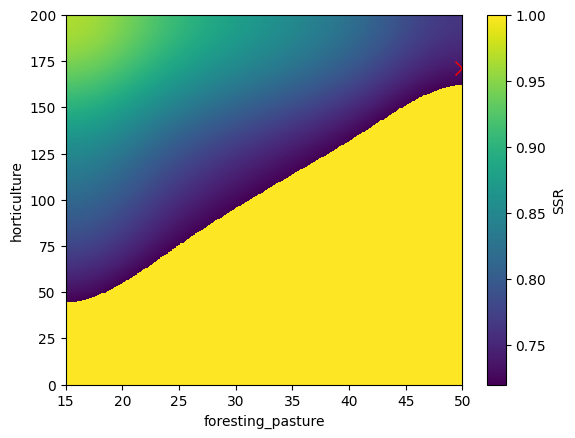

In [14]:
# Plot the resulting SSR w mask
plt.imshow(z1_mati_mask, cmap='viridis', interpolation='nearest', extent=[x_mins[1], x_maxs[1], x_mins[0], x_maxs[0]], origin='lower', aspect='auto')
plt.plot(x2_best, x1_best, marker='x', color='red', markersize=10)
plt.colorbar(label=z1_name)
plt.ylabel(name1)
plt.xlabel(name2)

Text(0.5, 0, 'foresting_pasture')

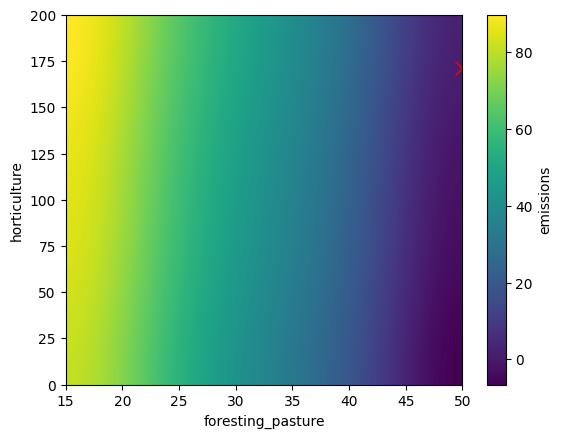

In [15]:
# Plot the resulting emissions
plt.imshow(z2_mati, cmap='viridis', interpolation='nearest', extent=[x_mins[1], x_maxs[1], x_mins[0], x_maxs[0]], origin='lower', aspect='auto')
plt.plot(x2_best, x1_best, marker='x', color='red', markersize=10)
plt.colorbar(label=z2_name)
plt.ylabel(name1)
plt.xlabel(name2)

Text(0.5, 0, 'foresting_pasture')

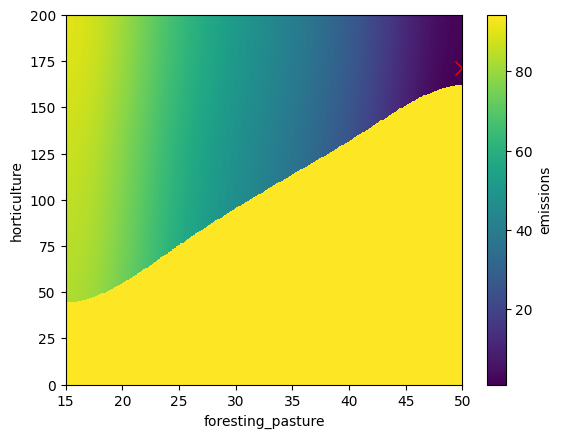

In [16]:
# Plot the resulting emissions, w mask
plt.imshow(z2_mati_mask, cmap='viridis', interpolation='nearest', extent=[x_mins[1], x_maxs[1], x_mins[0], x_maxs[0]], origin='lower', aspect='auto')
plt.plot(x2_best, x1_best, marker='x', color='red', markersize=10)
plt.colorbar(label=z2_name)
plt.ylabel(name1)
plt.xlabel(name2)

In [17]:
# Set the bounds for the optimisation - to be the same as for the grid
x_bounds = bounds=[(x_mins[0], x_maxs[0]), (x_mins[1], x_maxs[1])] # todo make this nd

In [18]:
# Set the constraint that SSR - SSR_threshold >=0
def make_constraint_SSR(SSR_threshold, names_x, datablock_init, params_baseline, sector_emissions_dict):
    def constraint_SSR(x):

        # Ideally figure out how to pass stuff from the objective function call into here to avoid re-running the objective function
        #fun, ffc_results = ffc_objective(x, names_x, datablock_init, params_baseline, sector_emissions_dict)
        #SSR_val, emissions_val = list(ffc_results.values())[:2]

        SSR_val = ffc_objective(x, names_x, "SSR", datablock_init, params_baseline, sector_emissions_dict)
        return SSR_val - SSR_threshold
    
    return constraint_SSR

In [19]:
# Set tolerances, verbosity, and options for the minimizer
ffc_tol = 1e-6
options = {
    'disp': True,      # Show convergence messages
    'maxiter': 100,     # Max number of iterations
    'rhobeg' : 10 # Reasonable step size (mostly they are percentages, so change by 10%)
}


In [20]:
ffc_wrapper = FFCObjectiveWithCache(names_x, datablock_init, params_baseline, sector_emissions_dict)

z_name_requested = "emissions"
x0 = [params_baseline[n] for n in names_x]
ffc_constraints = [{'type': 'ineq', 'fun': lambda x: ffc_wrapper.constraint_SSR(x, SSR_threshold=0.7202)}]

result = minimize(
    lambda x: ffc_wrapper.objective(x, z_name_requested),
    x0,
    method='COBYLA',
    bounds=x_bounds,
    constraints=ffc_constraints,
    tol=ffc_tol,
    options=options
)


   Normal return from subroutine COBYLA

   NFVALS =   40   F = 9.213995E-01    MAXCV = 1.110223E-16
   X = 1.710751E+02   5.000000E+01


In [21]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.9213994682198319
       x: [ 1.711e+02  5.000e+01]
    nfev: 40
   maxcv: 1.1102230246251565e-16

In [22]:
# The result is an OptimizeResult object
print("Optimization success:", result.success)
print("Message:", result.message)
print("Number of iterations:", result.nfev)
print("Optimal value of x:", result.x)
print("Minimum value of function:", result.fun)

Optimization success: True
Message: Optimization terminated successfully.
Number of iterations: 40
Optimal value of x: [171.07509035  50.        ]
Minimum value of function: 0.9213994682198319


In [23]:
print(result['x'])      # Optimal parameters
print(result['fun'])    # Minimum value of the objective
print(result['success'])  # Boolean indicating if it was successful

[171.07509035  50.        ]
0.9213994682198319
True


In [24]:
# Display the results
#z1_val, z2_val = list(ffc_results.values())[:2]
z1_val = ffc_objective(result.x, names_x, z1_name, datablock_init, params_baseline, sector_emissions_dict)
z2_val = ffc_objective(result.x, names_x, z2_name, datablock_init, params_baseline, sector_emissions_dict)
print(f"{z1_name} = {z1_val:.8f}; {z2_name} = {z2_val:.8f}")


horticulture = 171.0750903519; foresting_pasture = 50.0000000000; SSR = 0.7202000000; emissions = 0.9213994682; 
horticulture = 171.0750903519; foresting_pasture = 50.0000000000; SSR = 0.7202000000; emissions = 0.9213994682; 
SSR = 0.72020000; emissions = 0.92139947
